In [3]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(GGally)
options(repr.matrix.max.rows = 6)
options(repr.plot.height = 9, repr.plot.width = 9)

In [6]:
# Column names are:
# M_IP -> Mean of the Integrated Profile
# SD_IP -> Standard deviation of the Integrated Profile
# EK_IP -> Excess kurtosis of the Integrated Profile
# SK_IP -> Skewness of the Integrated Profile
# M_DM_SNR -> Mean of the DM-SNR curve
# SD_DM_SNR -> Standard deviation of the DM-SNR curve
# EK_DM_SNR -> Excess kurtosis of the DM-SNR curve
# SK_DM_SNR -> Skewness of the DM-SNR curve
# CLASS -> Label for an observation pulsar(1) and non-pulsar(0)
pulsar <- read_csv("HTRU_2.csv", 
                   col_names = c("M_IP","SD_IP","EK_IP","SK_IP","M_DM_SNR","SD_DM_SNR","EK_DM_SNR","SK_DM_SNR","CLASS")) |>
                mutate(CLASS = as_factor(CLASS))
pulsar
# CLASS variable is converted from double to factor type with two levels
# The data is tidy

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): M_IP, SD_IP, EK_IP, SK_IP, M_DM_SNR, SD_DM_SNR, EK_DM_SNR, SK_DM_SN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [9]:
set.seed(4)
pulsar_split <- initial_split(pulsar, prop = 0.8, strata = CLASS)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



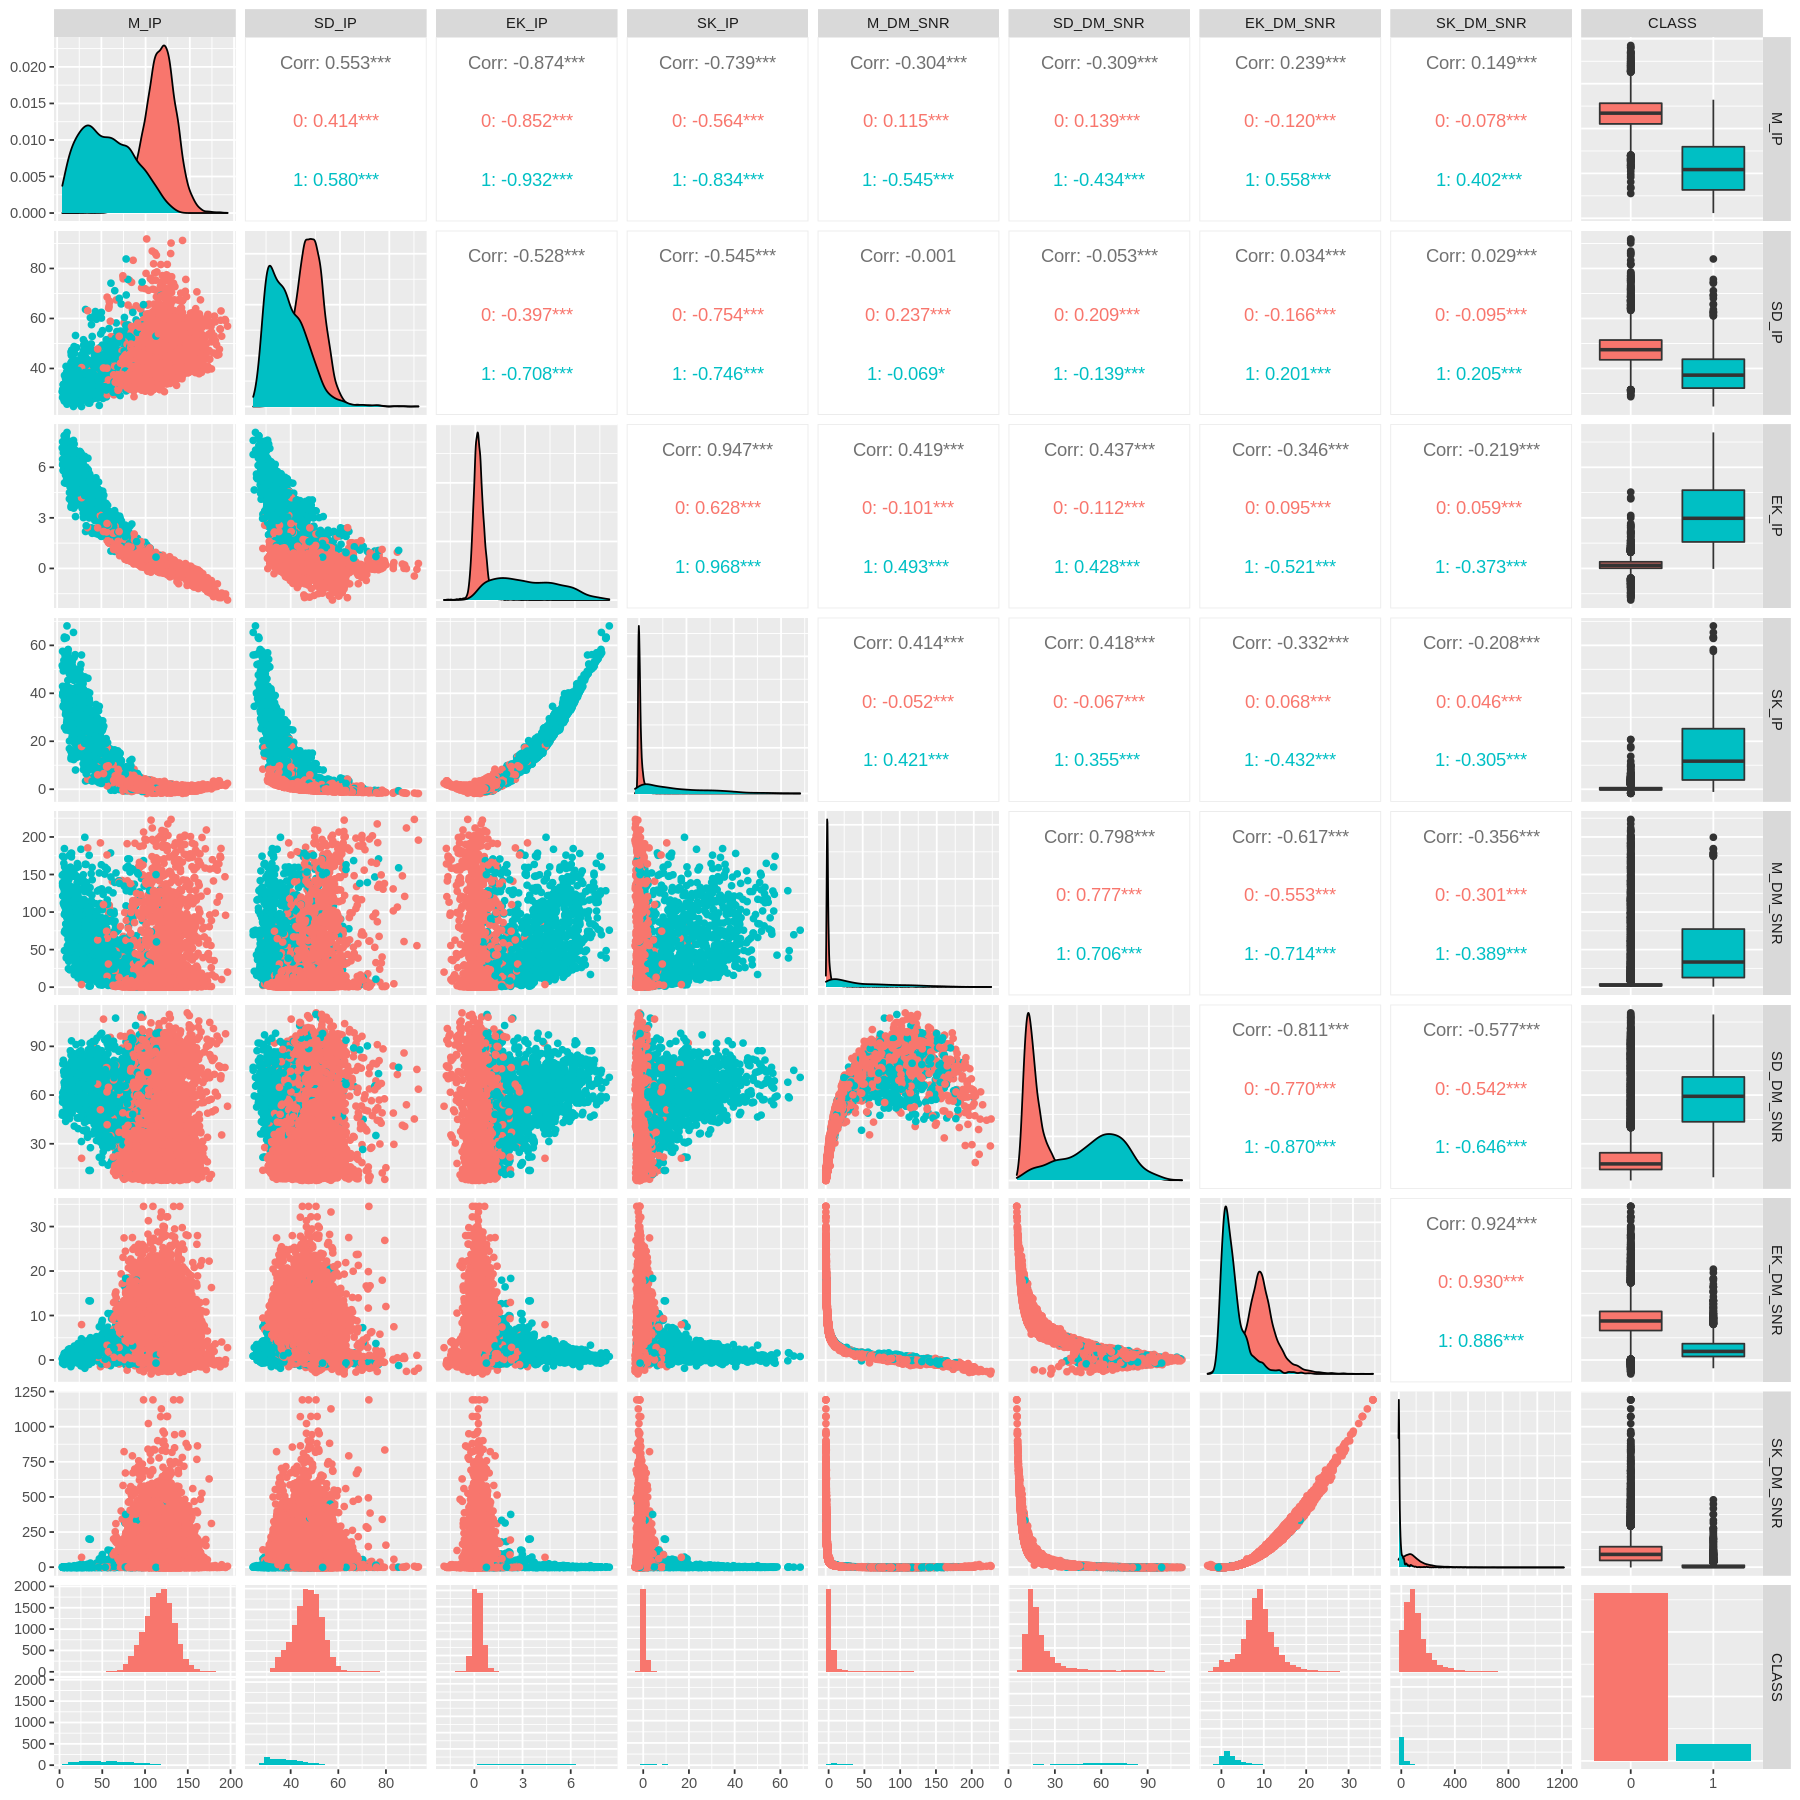

In [8]:
options(repr.plot.height = 15, repr.plot.width = 15)
pair_plot <- ggpairs(pulsar_train,aes(color = CLASS))
pair_plot

In [10]:
# training data is too large for forward selection so we use a smaller subset called pulsar_small_train
set.seed(4)
pulsar_train_split <- initial_split(pulsar_train, prop = 0.3, strata = CLASS)
pulsar_small_train <- training(pulsar_train_split)
pulsar_validation <- testing(pulsar_train_split)

In [11]:
set.seed(4)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_fwd_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5 fold cross-validation object
pulsar_fwd_vfold <- vfold_cv(pulsar_small_train, v = 5, strata = CLASS)

# names of predictors
names <- colnames(pulsar_small_train |>
                     select(-CLASS)) 

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("CLASS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_fwd_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_small_train) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors()) |>
                            step_upsample(CLASS, over_ratio = 1)

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(pulsar_fwd_recipe) |>
          add_model(knn_fwd_spec) |>
          tune_grid(resamples = pulsar_fwd_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,CLASS ~ EK_IP,0.9632130
2,CLASS ~ EK_IP+SD_IP,0.9701979
3,CLASS ~ EK_IP+SD_IP+M_DM_SNR,0.9718277
⋮,⋮,⋮
6,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR,0.9683353
7,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR,0.9683353
8,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK_DM_SNR,0.9678696


In [17]:
print(accuracies)

# A tibble: 8 × 3
   size model_string                                                    accuracy
  <int> <chr>                                                              <dbl>
1     1 CLASS ~ EK_IP                                                      0.963
2     2 CLASS ~ EK_IP+SD_IP                                                0.970
3     3 CLASS ~ EK_IP+SD_IP+M_DM_SNR                                       0.972
4     4 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP                                 0.973
5     5 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP                            0.971
6     6 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR                  0.968
7     7 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR        0.968
8     8 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK…    0.968


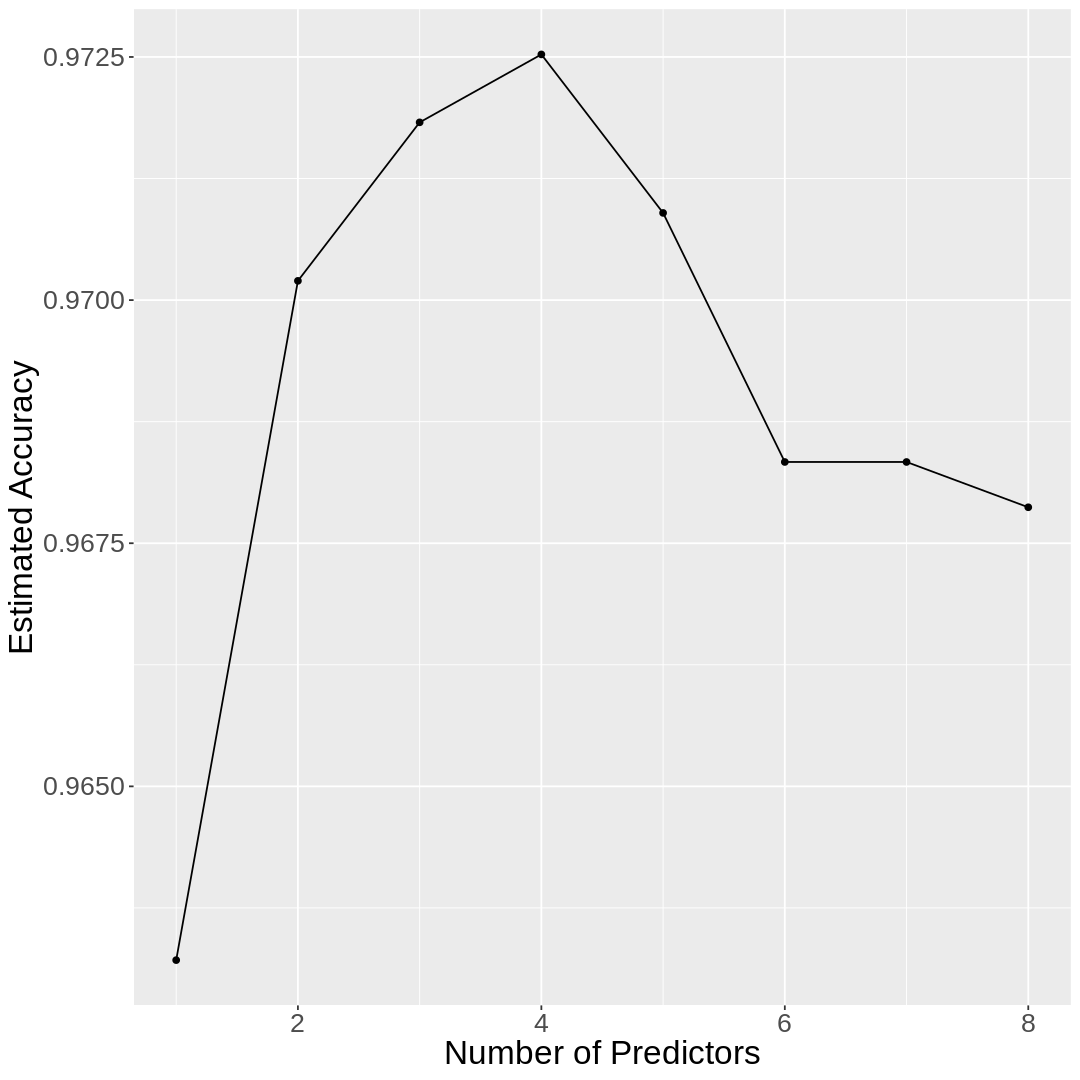

In [12]:
options(repr.plot.height = 9, repr.plot.width = 9)
accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Predictors", y = "Estimated Accuracy") +
                    theme(text = element_text(size = 20))
accuracies_plot

In [22]:
pulsar_recipe <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1, skip = FALSE) |>
                    prep() |>
                    bake(pulsar_train) 
pulsar_train |>
count(CLASS)

CLASS,n
<fct>,<int>
0,13005
1,1313


In [16]:
set.seed(4)
# create a model specification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

# create a model recipe using the predictor variables as given from forward selection
pulsar_recipe <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1)

# make a 5 fold cross-validation object using entire training dataset
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = CLASS)

# grid of neighbor values
grid_vals <- tibble(neighbors = seq(1:50))

# fit the model onto the training data and collect estimated accuracy vs neighbors data
pulsar_eaccuracy <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_tune_spec) |>
                tune_grid(resamples = pulsar_vfold, grid = grid_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

estimate_accuracy_vs_k <- ggplot(pulsar_eaccuracy, aes(x = neighbors, y = mean)) +
                            geom_point() +
                            geom_line() +
                            labs(x = "Neighbors", y = "Estimated Accuracy") +
                            theme(text = element_text(size = 20))

In [23]:
pulsar_eaccuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model01
2,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model02
3,accuracy,binary,0.9643109,5,0.0014860142,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.9658469,5,0.002416428,Preprocessor1_Model48
49,accuracy,binary,0.9668246,5,0.002584216,Preprocessor1_Model49
50,accuracy,binary,0.9668246,5,0.002584216,Preprocessor1_Model50


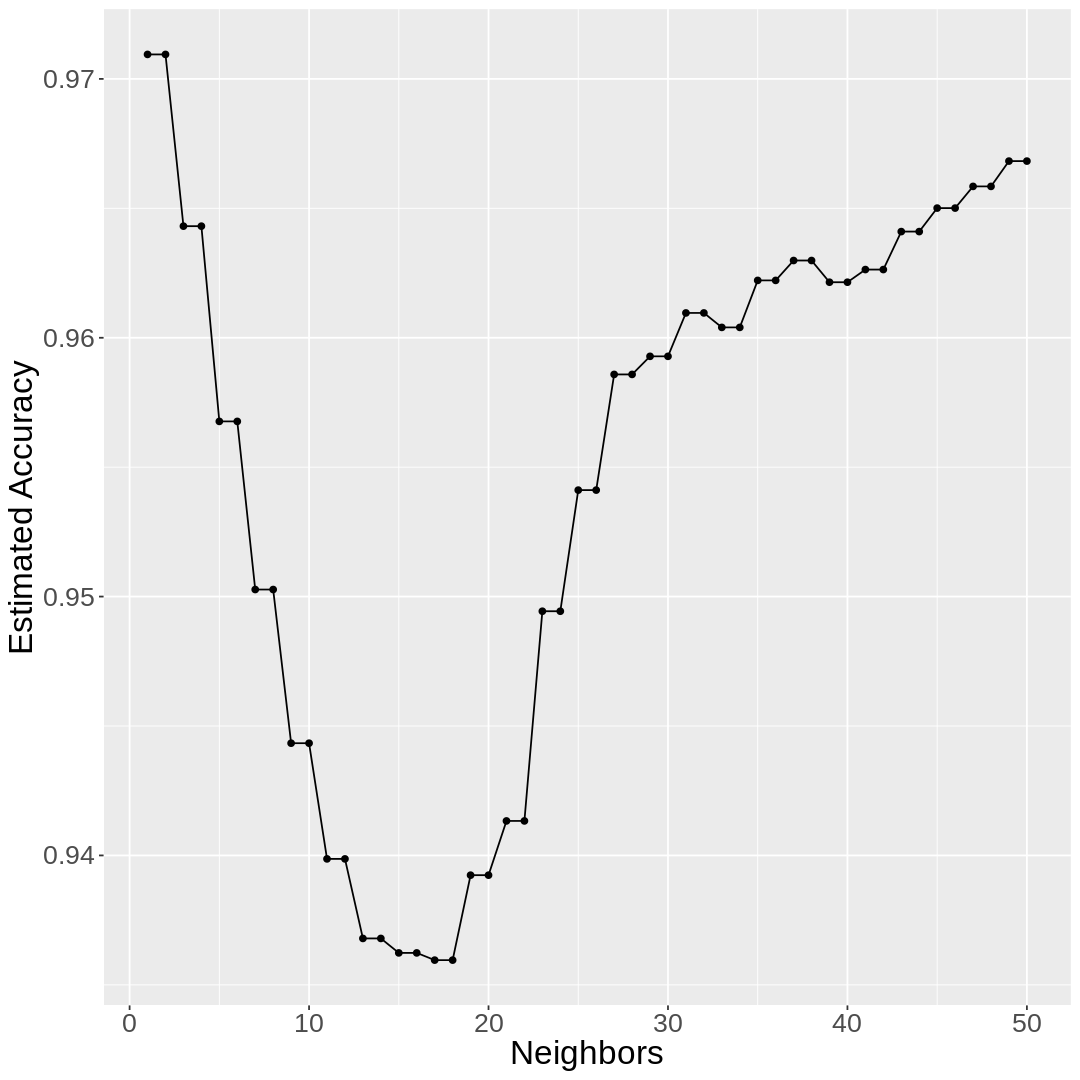

In [18]:
estimate_accuracy_vs_k

In [15]:
set.seed(4)
# create a new model specification using the best neighbor value
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
                set_engine("kknn") |>
                set_mode("classification")

# we can reuse the old recipe

# fir model onto the training data
pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_best_spec) |>
                fit(pulsar_train) 

# predict labels for test data observations and join with original table
pulsar_predict <- predict(pulsar_fit, pulsar_test) |>
                    bind_cols(pulsar_test)

# Calculate accuracy of our model predicting on testing data
pulsar_accuracy <- pulsar_predict |>
                    metrics(truth = CLASS, estimate = .pred_class)
pulsar_accuracy

# confusion matrix for our model predicting on testing data
pulsar_conf_mat <- pulsar_predict |>
                    conf_mat(truth = CLASS, estimate = .pred_class)

pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9675978
kap,binary,0.8042617


          Truth
Prediction    0    1
         0 3196   58
         1   58  268